In [ ]:
#Database
"""from zipfile import *
file_name = "/content/Face_Recognition.zip"
with ZipFile(file_name, 'r') as zf:
  zf.extractall()
  print('Done')"""

'from zipfile import *\nfile_name = "/content/Face_Recognition.zip"\nwith ZipFile(file_name, \'r\') as zf:\n  zf.extractall()\n  print(\'Done\')'

In [ ]:
!pip install mtcnn

In [ ]:
import sys
sys.path.insert(0,'/content/Face Recognition')

In [ ]:
from mtcnn.mtcnn import MTCNN
import tensorflow as tf
import os
import numpy as np
import cv2
from architecture_facenet import InceptionResNetV2

In [ ]:
#1. Create the face detection model
#using MTCNN
face_detector = MTCNN()

#2. Create FaceNet
weight_path = "/content/Face Recognition/Weight/facenet_keras_weights.h5"
model = InceptionResNetV2()
model.load_weights(weight_path)

#3. Face database path
face_database_path = "/content/Face Recognition/Database"

#Global variable for color and thickness of th rect and point 
colour = (0,255,0) #Green in RGB
thickness = 2

#4. Create a function to obtain a bounding box result
def get_xy(box):
  x1,y1,width,height =  box
  x1,y1 = abs(x1),abs(y1)
  x2,y2 = x1+width,y1+height
  return x1,y1,x2,y2

#5. Create a function that wil output face result
def get_face(image,resize_scale=(160,160)):
  face_list=[]
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  #using MTCNN to detect all the faces appeared in an image
  face_detected = face_detector.detect_faces(image)
  #create for loop to loop through each individual face detection result
  for detected_face in face_detected:
    x1,y1,x2,y2 = get_xy(detected_face['box'])
    #crop out face
    final_face = image[y1:y2,x1:x2]
    #resize the image
    face_array = cv2.resize(final_face,resize_scale)
    face_list.append(face_array)

  #Return a list of detected face image and output of MTCNN
  return face_list, face_detected 

#Create function that will use FaceNet to produce embeddings
def get_face_embeddings(face_image):
  #change the data type of the pixels
  face_image = face_image.astype('float32')
  #normalize the pixel values
  mean, std = face_image.mean(), face_image.std()
  face_image = (face_image - mean) / std
  #Expand dimension so that the model can take in
  samples = np.expand_dims(face_image, axis=0)
  #use the FaceNet to produce embeddings
  embeddings =  model.predict(samples)
  return embeddings

#7. create a function that will load the databases
def load_saved_user():
  #empty list to store the embeddings of the face in dataset and the name
  saved_faces = [] 
  saved_faces_name = []
  #List down all the images in databases
  face_database = os.listdir(face_database_path)
  #read the image then use FaceNet to produce the embeddings for comparison  later
  if face_database:
    for face_img in face_database:
      #read the image with OpenCV
      image_np = cv2.imread(os.path.join(face_database_path, face_img))
      face_list, detected_faces = get_face(image_np)
      #assume database is tightly controlled (means that each database  only has one face)
      face_embedding = get_face_embeddings(face_list[0])
      #Append to the empty list
      saved_faces.append(face_embedding)
      saved_faces_name.append(face_img.split(',')[0])

  else: 
    print("No face available in the database")

  return saved_faces, saved_faces_name

#8. create a function that will draw all the detected faces (bounding boxes and keypoints)
def mark_face(detected_face,image,x1,x2,y1,y2):
  #get the face keypoints
  left_eye = detected_face['keypoints']['left_eye']
  right_eye = detected_face['keypoints']['right_eye']
  nose = detected_face['keypoints']['nose']
  left_mouth = detected_face['keypoints']['left_mouth']
  right_mouth = detected_face['keypoints']['right_mouth']

  #draw the detected face with a rectangle (for the bounding box)
  image = cv2.rectangle(image,(x1,y1), (x2,y2), colour, thickness)
  #draw the facial keypoints with circles
  image = cv2.circle(image, left_eye, radius=2,color=colour,thickness=-1)
  image = cv2.circle(image, right_eye, radius=2,color=colour,thickness=-1)
  image = cv2.circle(image, nose, radius=2,color=colour,thickness=-1)
  image = cv2.circle(image, left_mouth, radius=2,color=colour,thickness=-1) 
  image = cv2.circle(image, right_mouth, radius=2,color=colour,thickness=-1)

  return image

#9. Create a function that will perform face verification
def verify(target_image,threshold=10):
  #(a)load data from database
  saved_faces,saved_faces_names = load_saved_user()
  #(b)perform face detection on target image, only if  there's
  if saved_faces:
    target_faces, detected_faces = get_face(target_image)
    #(c) if there are face detected,  we will perform recognition
    if target_faces:
      for target_face, detected_face in zip(target_faces,detected_faces):
        #(d)get embedding from the target face
        target_face_embedding = get_face_embeddings(target_face)
        #(e)compare the target face with all the data in database
        for every_face, name in zip(saved_faces,saved_faces_names):
          #(f)measure similarity with Eud distance
          dist = np.linalg.norm(every_face - target_face_embedding)
          #(g) if distance lower than threshold, two image would be consider similar
          if dist < threshold:
            #(h) displa the face recognition result
            x1,y1,x2,y2 = get_xy(detected_face['box'])
            target_image = mark_face(detected_face,target_image,x1,x2,y1,y2)
            target_image = cv2.putText(target_image,
                                       name+f"__distance:{dist:.2f}",
                                       (x1,y1-10),cv2.FONT_HERSHEY_COMPLEX,
                                       0.6,colour,thickness)

    else:
      print("No face detected in the image")
  return target_image


In [ ]:
#10(a) Open webcam and perform face recognition (local)
camera = cv2.VideoCapture(0)

while camera.isOpened():
  ret,frame = camera.read()
  if not ret:
    break

  #convert into numpy array
  image_np = np.array(frame)
  image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

  #run inference on the image frame
  drawn_image = verify(image_np)
  #dispaly result
  display_image = cv2.cvtColor(drawn_image, cv2.COLOR_BGR2RGB)
  cv2.imshow("Face verification", display_image)

  if cv2.waitKey(10) & 0xFF == ord('q'):
    break

camera.release()
cv2.destroyAllWindows

<function destroyAllWindows>

No face detected in the image


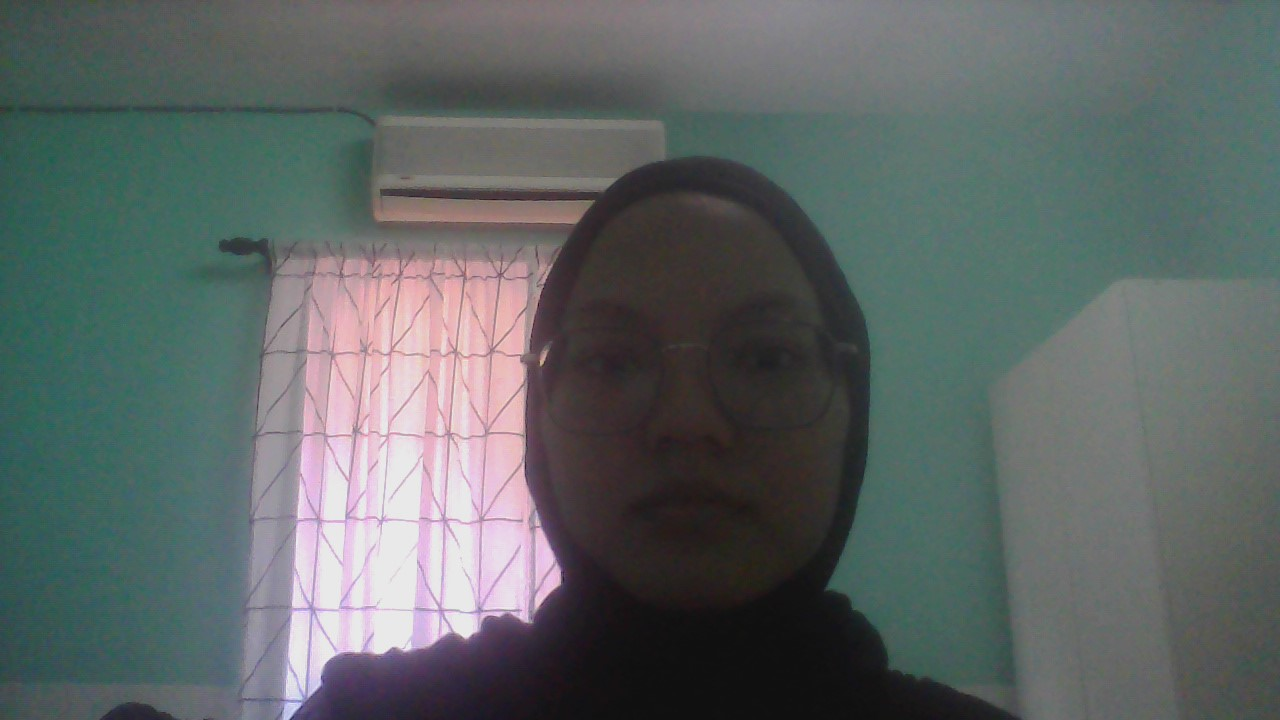

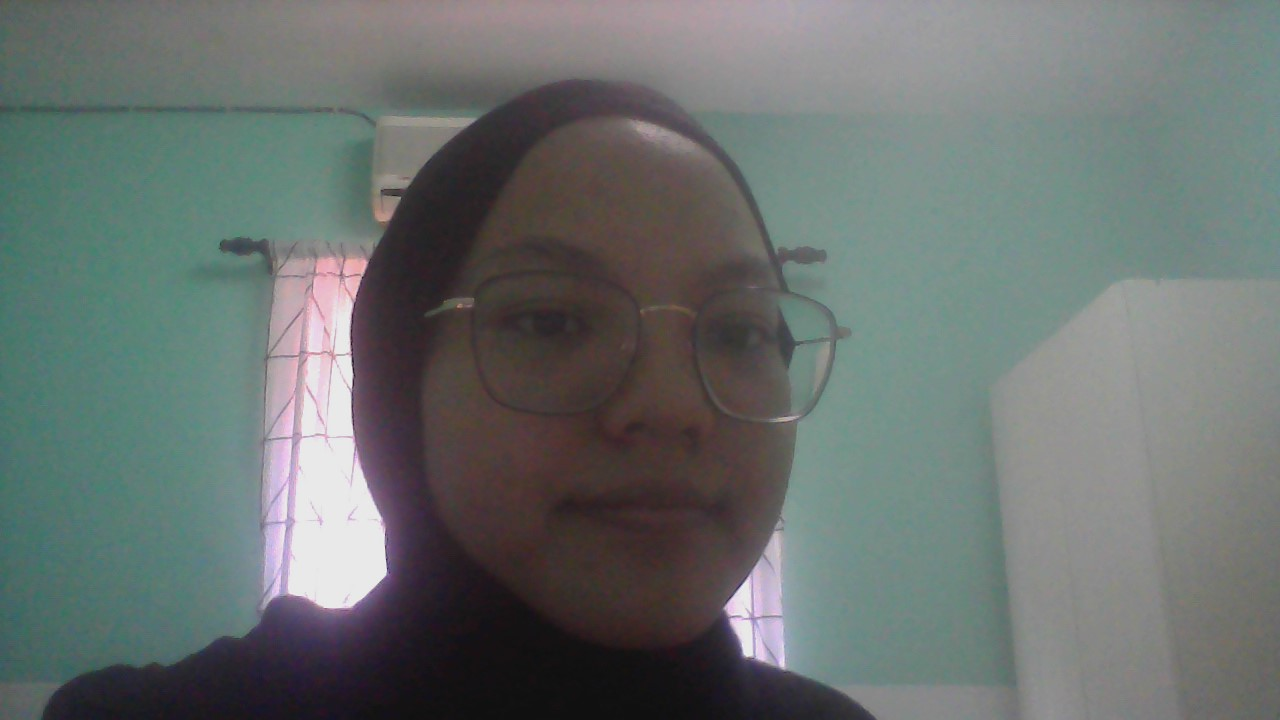

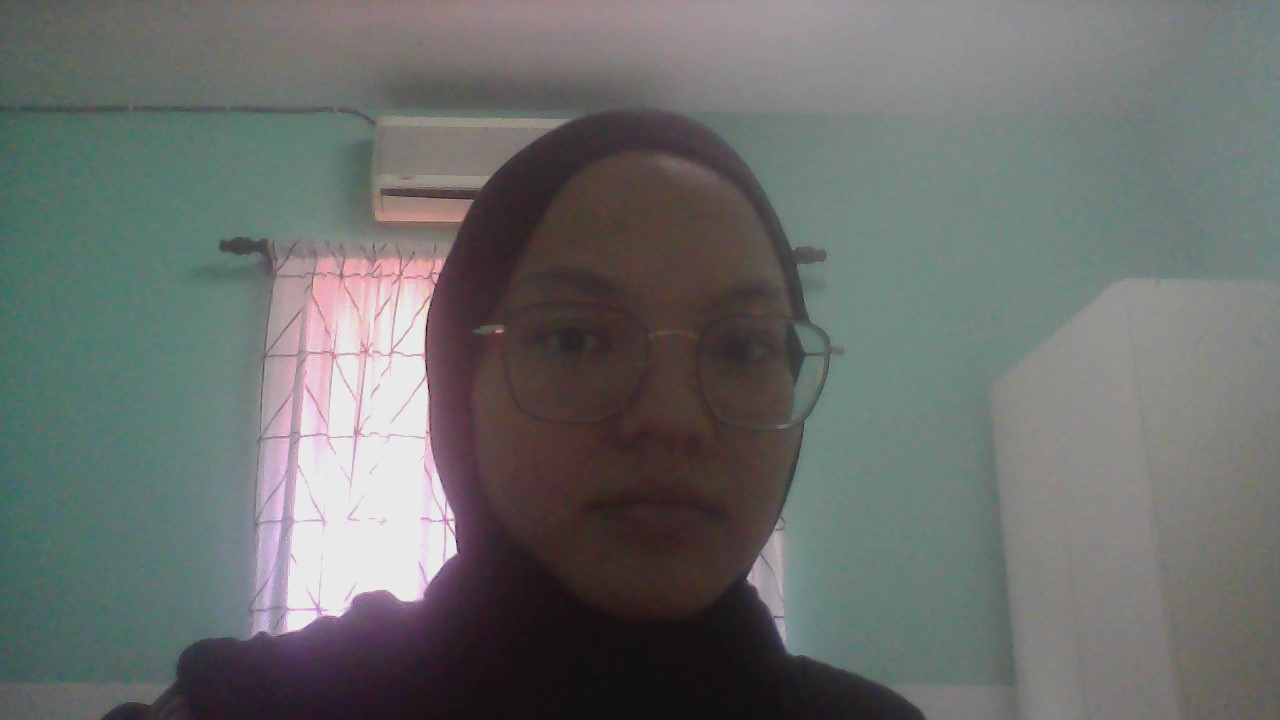

<function destroyAllWindows>

In [ ]:
#10(b) colab
from os import listdir
from google.colab.patches import cv2_imshow
file_path = "/content/Face Recognition/face to verify"
faces_to_verify = os.listdir(file_path)

#loop through image verification
for face_to_verify in faces_to_verify:
  complete_path = os.path.join(file_path,face_to_verify)
  image_np = cv2.imread(complete_path)
  image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

  #run inference on the image frame
  drawn_image = verify(image_np)
  #dispaly result
  display_image = cv2.cvtColor(drawn_image, cv2.COLOR_BGR2RGB)
  cv2_imshow(display_image)
  cv2.waitKey(0)

cv2.destroyAllWindows